In [1]:
'''
在音调上面做不出来，

可能性:某些脑组织-对应某些频段，能携带音调信息。

怎么架构矩阵呢？




第一步是计算出每个channel的30Hz处的数据


'''

'\n在音调上面做不出来，\n\n可能性:某些脑组织-对应某些频段，能携带音调信息。\n\n怎么架构矩阵呢？\n\n\n\n\n第一步是计算出每个channel的30Hz处的数据\n\n\n'

In [2]:
import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

2.031606678006707


In [3]:
sub_ids = [

    "pre2003",

]
file_path = 'E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\\6epoch_clean_RSA\\'

data_path = file_path + sub_ids[0] + '_RSA-epo.fif'

epochs_all = mne.read_epochs(fname=data_path)

#如果需要子集
channels_nieye = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']

# 如果只想看某一部分的脑区,配合更改ndarray的维度
# epochs_nieye = epochs_all.pick(picks=channels_nieye)

'''
思路，先求ERP，然后再给ndarray，然后再计算RDM
'''


Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_RSA\pre2003_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1673 matching events found
No baseline correction applied
0 projection items activated


'\n思路，先求ERP，然后再给ndarray，然后再计算RDM\n'

In [4]:
'''
做时频分析
ba1.wav	1	101
ba2.wav	1	102
ba3.wav	1	103
ba4.wav	1	104
da1.wav	1	111
da2.wav	1	112
da3.wav	1	113
da4.wav	1	114
ma1.wav	1	121
ma2.wav	1	122
ma3.wav	1	123
ma4.wav	1	124
wa1.wav	1	131
wa2.wav	1	132
wa3.wav	1	133
wa4.wav	1	134
zha1.wav	1	141
zha2.wav	1	142
zha3.wav	1	143
zha4.wav	1	144
'''


#采样率
sfreq = 1000
#20种刺激的psds，先拿一个刺激的出来看看。
#
'''
先尝试对一种刺激的epoch做tfr，看看数据结构怎么样。
'''
freqs = np.linspace(1, 40, num=40)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs_all['101'], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=1, n_jobs=1)

#epochs_all.plot_sensors(show_names=True)
# print(power.data.shape)
'''
所以你需要提取出来每个被试每个频段是(62，334)

问题为何只有334了,是decim=3导致的，三个点取一个点。
'''

# （channel=62,timepoint=1001）
nd_power = power.data[:,30,:]


In [16]:
conds = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', '141', '142', '143', '144']
# 单个被试的数据
subdata = np.zeros([20, 62, 1001], dtype=np.float32)
subdata[0] = nd_power

In [26]:
'''
生成每种条件对应的evoked
而且是按照次序
'''
conds = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', '141', '142', '143', '144']

#批处理准备的，这里单被试没有实际作用。
sub_ids = ['pre2001',]
eegdata = np.zeros([len(sub_ids),20, 62, 1001], dtype=np.float32)
#初始值
subindex = 0
for m in range(len(sub_ids)):
    #单个被试的数据
    subdata = np.zeros([20, 62, 1001], dtype=np.float32)
    for i in range(len(conds)):
        epochs = epochs_all[conds[i]]
        power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=1, n_jobs=1)

        nd_power = power.data[:,30,:]
        data = nd_power
        subdata[i] = data
    eegdata[m] = subdata

In [27]:
# shape of megdata: [n_subs, n_cons, n_chls, n_ts] -> [n_cons, n_subs, n_chls, n_ts]
eegdata = np.transpose(eegdata, (1, 0, 2, 3))
eegdata1 =eegdata
# shape of megdata: [n_cons, n_subs, n_chls, n_ts] -> [n_cons, n_subs, n_trials, n_chls, n_ts]
# here data is averaged, so set n_trials = 1
eegdata = np.reshape(eegdata, [20, len(sub_ids), 1, 62, 1001])



Computing RDM

RDM computing finished!


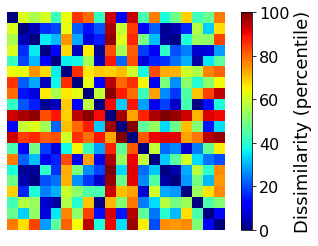

0

In [28]:
# Calculate the RDM based on the data during 190ms-210ms
rdm = eegRDM(eegdata[:, :, :, :, 340:350], sub_opt=0)

# Plot this RDM
plot_rdm(rdm, percentile=True)


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDM computing finished!


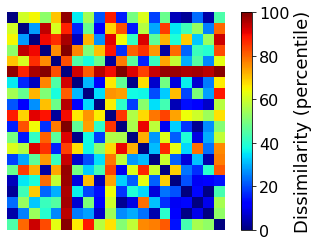

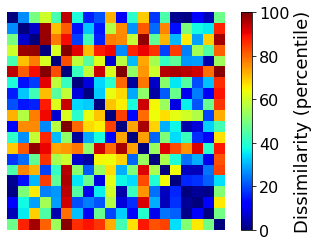

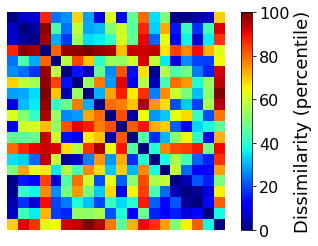

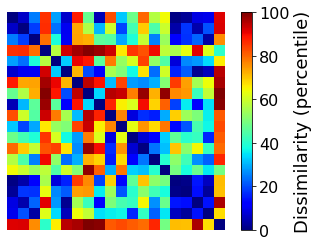

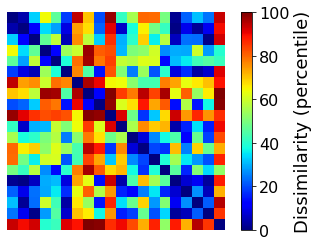

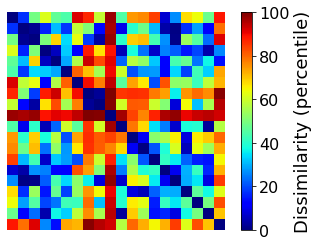

In [29]:
# Calculate the RDMs by a 10ms time-window
# (raw sampling requency is 1000Hz, so here time_win=10ms/(1s/1000Hz)/1000=10)
rdms = eegRDM(eegdata, time_opt=1, time_win=50, time_step=5, sub_opt=0)

# Plot the RDM of -100ms, 0ms, 50ms, 100ms, 150ms, 200ms
times = [0, 10, 20, 30, 40, 50,]
for t in times:
    plot_rdm(rdms[t], percentile=True)

In [30]:
'''
构造模型矩阵
'''

RDM_model_fuyin = np.zeros([20,20], dtype=np.float32)
# for i in range(20):
#     for j in range(20):
#         if abs(i-j)<=3:
#             RDM_model_fuyin[i,j] = 0
#         else:
#             RDM_model_fuyin[i,j] =
zeroM = np.zeros([4,4], dtype=np.float32)
oneM =  np.ones((4, 4), dtype=np.float32)

a1=np.concatenate((zeroM,oneM,oneM,oneM,oneM,),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM,oneM,),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM,oneM,),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM,oneM,),axis = 1)
a5=np.concatenate((oneM,oneM,oneM,oneM,zeroM),axis = 1)
RDM_model_fuyin = np.concatenate((a1,a2,a3,a4,a5),axis=0)



Computing similarities

Computing finished!


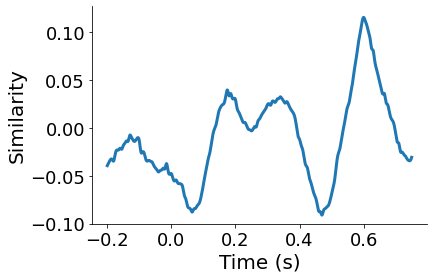

0

In [31]:
# Calculate the representational similarity between 200ms and all the time points
corrs1 = rdms_corr(RDM_model_fuyin, rdms)

# Plot the corrs1
corrs1 = np.reshape(corrs1, [1, 191, 2])
plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])

In [32]:
'''
构造模型矩阵
'''

RDM_model_yindiao = np.zeros([20,20], dtype=np.float32)


oneM =  np.ones((4, 4), dtype=np.float32)
for i in range(4):
    oneM[i][i] = 0
zeroM = oneM

a1=np.concatenate((zeroM,oneM,oneM,oneM,oneM,),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM,oneM,),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM,oneM,),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM,oneM,),axis = 1)
a5=np.concatenate((oneM,oneM,oneM,oneM,zeroM),axis = 1)
RDM_model_yindiao = np.concatenate((a1,a2,a3,a4,a5),axis=0)


Computing similarities

Computing finished!


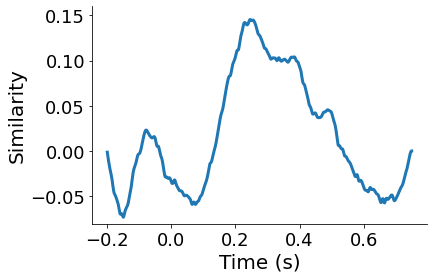

0

In [33]:
# Calculate the representational similarity between 200ms and all the time points
corrs1 = rdms_corr(RDM_model_yindiao, rdms)


# Plot the corrs1
corrs1 = np.reshape(corrs1, [1, 191, 2])
plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])

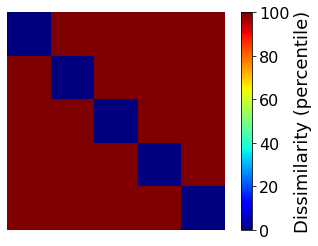

0

In [24]:
plot_rdm(RDM_model_fuyin, percentile=True)

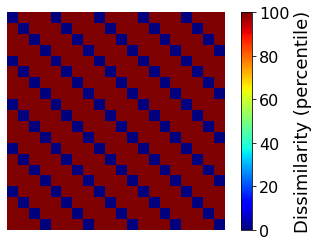

0

In [25]:
plot_rdm(RDM_model_yindiao, percentile=True)